# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Мажаров".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w} = \frac{\sum_i \log(1 + e^{-y^{(i)} \langle w, x^{(j)}\rangle} + \frac{1}{C}\sum_i w_i^{2}}{\partial w} = \sum_i{\frac{-y^{(i)}x^{(i)}}{1 + e^{y\langle w, x^{(i)} \rangle}}} + \frac{2}{C}\sum_i w_i$$

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=100):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        #Обучение модели
        
        #Массивы коэфициентов и ошибок на каждой эпохе
        n_samples, n_features = X.shape
        self.coef = np.ones(n_features+1)
        self.errors = np.empty(self.max_epoch)
        
        #Дополнительный столбец для свободного коэффициента
        X = np.hstack((np.ones((n_samples, 1)), X))
        #Приводим значения класса к -1, +1
        y = (y-0.5)*2
        
        for epoch in range(self.max_epoch):
            #Массивы батчей
            inds = np.random.permutation(np.arange(X.shape[0]))
            Xb = np.array([X[inds[i:i + self.batch_size]] for i in range(0, X.shape[0], self.batch_size)])
            yb = np.array([y[inds[i:i + self.batch_size]] for i in range(0, X.shape[0], self.batch_size)])

            for i in xrange(Xb.shape[0]):
                #Предсказание класса
                predict = Xb[i].dot(self.coef)
                margin = yb[i]*predict
                
                #Вычисление градиента - производной от функции потерь
                grad = - (Xb[i].T).dot(yb[i]/(1 + np.e**margin)) + 2./self.C*self.coef
                #Обновление коэффициентов
                self.coef = self.coef - self.alpha / (1 + epoch) * grad
            
            self.errors[epoch] = np.sum(np.log(1 + np.e**(-y*X.dot(self.coef)))) 
            
        return self
    
    def partial_fit(self, X, y=None):
        #По желанию - метод дообучения модели на новых данных
        
        return self
        
    def predict(self, X):
        #Возвращение метки класса
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_hat = np.sign(X.dot(self.coef))/2+0.5
        
        return y_hat
    
    def predict_proba(self, X):
        #Возвращение вероятности каждого из классов
        
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

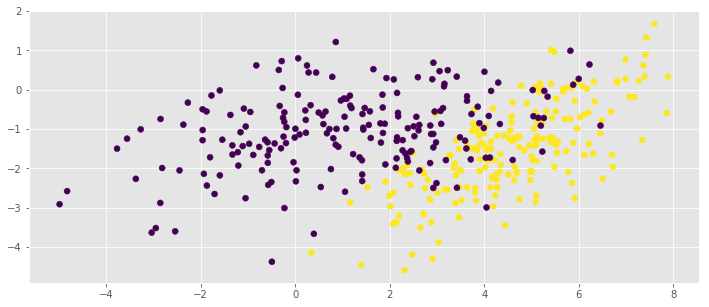

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
model = MySGDClassifier(max_epoch=40, C=100, batch_size=32, alpha=0.04)
model.fit(X, y)

MySGDClassifier(C=100, alpha=0.04, batch_size=32, max_epoch=40)

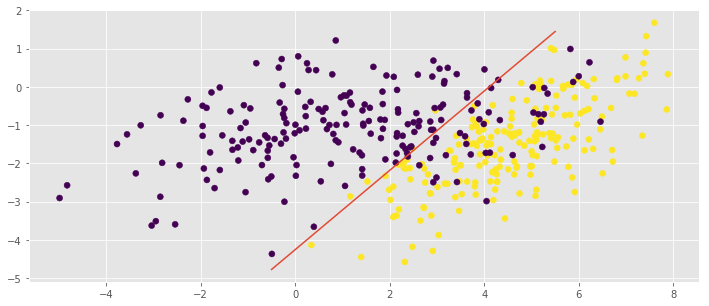

In [6]:
coef = model.coef
plt.scatter(X[:,0], X[:,1], c=y)
x = np.arange(-0.5, 6.5, 1)
plt.plot(x, -coef[1]/coef[2]*x - coef[0]/coef[2])

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [7]:
from sklearn.datasets import make_classification

In [8]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

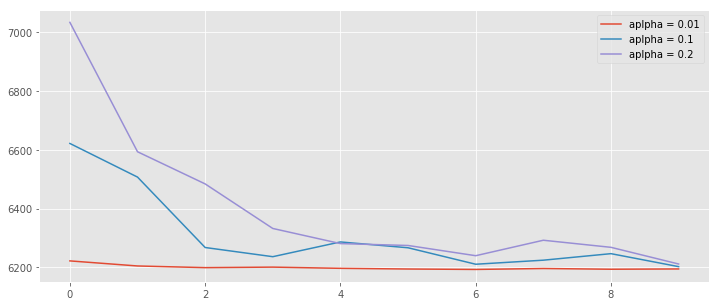

In [9]:
## Your Code Here
model = MySGDClassifier(C=100, alpha=0.01)
model.fit(X, y)
err_1 = model.errors

model = MySGDClassifier(C=100, alpha=0.1)
model.fit(X, y)
err_2 = model.errors

model = MySGDClassifier(C=100, alpha=0.2)
model.fit(X, y)
err_3 = model.errors

plt.plot(range(err_1.shape[0]), err_1, label='aplpha = 0.01')
plt.plot(range(err_2.shape[0]), err_2, label='aplpha = 0.1')
plt.plot(range(err_3.shape[0]), err_3, label='aplpha = 0.2')
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

C:\Users\Ivan\Anaconda2\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in power


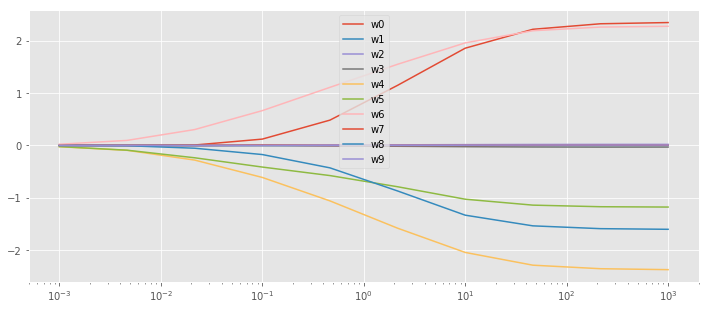

In [10]:
## Your Code Here
coef = []
for C in np.logspace(3, -3, 10):
    model = MySGDClassifier(C=C, alpha=0.001)
    model.fit(X, y)
    coef.append(model.coef)

coef = np.array(coef)
for idx in range(10):
    plt.plot(np.logspace(3,-3, 10), coef[:,idx], label='w'+str(idx))
plt.legend()
plt.xscale('log')

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [12]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
#filepath = './trainingData_tabular_chunk1.csv'
#df_data = pd.read_csv(filepath, sep=',')

In [13]:
df_data.shape

(2000000, 45)

In [14]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [15]:
df_data.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346.0,1,14,0,0,798,5,0,0,10,10,...,20,23,4,0,1,5,0,20,22,17
3270826.0,1,7,0,0,754,22,0,0,6,6,...,16,17,3,2,2,7,0,17,26,20
3189487.0,1,5,3,0,612,29,0,0,4,1,...,0,0,5,0,0,5,2,26,28,27
4098946.0,1,8,0,0,390,26,0,0,7,7,...,2,2,7,1,1,9,9,36,44,36
2661127.0,0,13,0,0,25,30,0,0,10,1,...,7,7,4,0,0,4,4,13,13,14


In [16]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.5047995

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [17]:
## Youd Code Here
n_unique = df_data.player_hero_card_id.nunique()
n_unique

9

In [18]:
cols_to_transform = ['opponent_hero_card_id', 'player_hero_card_id']
df_data_hot = pd.get_dummies(df_data, columns=cols_to_transform)

In [19]:
df_data_hot.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,opponent_deck_count,...,opponent_hero_card_id_1235,player_hero_card_id_25,player_hero_card_id_326,player_hero_card_id_390,player_hero_card_id_494,player_hero_card_id_612,player_hero_card_id_754,player_hero_card_id_798,player_hero_card_id_981,player_hero_card_id_1235
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346.0,1,14,0,0,5,0,0,10,10,11,...,0,0,0,0,0,0,0,0,1,0
3270826.0,1,7,0,0,22,0,0,6,6,19,...,0,0,0,0,0,0,1,0,0,0
3189487.0,1,5,3,0,29,0,0,4,1,22,...,0,0,0,0,0,1,0,0,0,0
4098946.0,1,8,0,0,26,0,0,7,7,17,...,0,0,0,0,0,0,0,0,1,0
2661127.0,0,13,0,0,30,0,0,10,1,12,...,0,0,0,0,1,0,0,0,0,0


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [20]:
## Youd Code Here
y_train = df_data_hot.decision.as_matrix()
y_train

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [21]:
X_train = df_data_hot.loc[:,'turn':].as_matrix()
X_train

array([[14,  0,  0, ...,  0,  1,  0],
       [ 7,  0,  0, ...,  0,  0,  0],
       [ 5,  3,  0, ...,  0,  0,  0],
       ..., 
       [ 4,  0,  0, ...,  0,  0,  0],
       [12,  3,  0, ...,  0,  0,  0],
       [ 6,  0,  0, ...,  0,  1,  0]], dtype=int64)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
model = Pipeline([('scaler', StandardScaler()), 
                         ('log_reg', MySGDClassifier())])

In [23]:
model.fit(X_train, y_train)

C:\Users\Ivan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('log_reg', MySGDClassifier(C=1, alpha=0.01, batch_size=100, max_epoch=10))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [25]:
# Загрузка данных целиком
df_list_test = []
for chunk in range(5,8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_list_test.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list_test)

In [26]:
df_data_test.shape

(1250000, 45)

In [27]:
# для удобства
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [28]:
df_data_test.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
1304374.0,NaN,5,0,0,981,23,0,0,4,0,...,5,5,2,1,0,3,1,6,11,9
4383331.0,NaN,9,0,3,754,16,0,1,8,3,...,9,12,3,1,0,4,4,13,14,13
3544947.0,NaN,16,0,0,798,16,1,0,10,2,...,20,29,0,1,0,1,0,0,5,0
4282915.0,NaN,3,0,0,326,30,0,0,2,2,...,0,0,3,1,0,4,0,12,12,11
4327924.0,NaN,5,0,0,25,30,0,0,4,1,...,1,3,2,2,0,4,0,8,15,9


In [29]:
## Youd Code Here
n_unique = df_data_test.player_hero_card_id.nunique()
n_unique

9

In [30]:
cols_to_transform = ['opponent_hero_card_id', 'player_hero_card_id']
df_data_hot_test = pd.get_dummies(df_data_test, columns=cols_to_transform)

In [31]:
df_data_hot_test.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,opponent_deck_count,...,opponent_hero_card_id_1235,player_hero_card_id_25,player_hero_card_id_326,player_hero_card_id_390,player_hero_card_id_494,player_hero_card_id_612,player_hero_card_id_754,player_hero_card_id_798,player_hero_card_id_981,player_hero_card_id_1235
gamestate_id,,,,,,,,,,,,,,,,,,,,,
1304374.0,NaN,5,0,0,23,0,0,4,0,21,...,0,0,0,0,0,1,0,0,0,0
4383331.0,NaN,9,0,3,16,0,1,8,3,17,...,0,0,0,0,0,0,0,1,0,0
3544947.0,NaN,16,0,0,16,1,0,10,2,9,...,0,1,0,0,0,0,0,0,0,0
4282915.0,NaN,3,0,0,30,0,0,2,2,24,...,0,0,0,0,0,0,1,0,0,0
4327924.0,NaN,5,0,0,30,0,0,4,1,22,...,0,0,1,0,0,0,0,0,0,0


In [32]:
X_test = df_data_hot_test.loc[:,'turn':].as_matrix()
X_test

array([[ 5,  0,  0, ...,  0,  0,  0],
       [ 9,  0,  3, ...,  1,  0,  0],
       [16,  0,  0, ...,  0,  0,  0],
       ..., 
       [12,  0,  0, ...,  1,  0,  0],
       [10,  0,  0, ...,  0,  0,  0],
       [15,  0,  0, ...,  0,  1,  0]], dtype=int64)

In [33]:
file = open('deprecated_testLabels.txt', 'r')

In [34]:
y_test = []
for item in file:
    y_test.append(int(item))
y_test = np.array(y_test)

In [35]:
y_test

array([1, 1, 1, ..., 0, 1, 0])

In [36]:
res = model.predict(X_test)

In [37]:
from sklearn.metrics import classification_report
print classification_report(y_test, res)

             precision    recall  f1-score   support

          0       0.70      0.72      0.71    619766
          1       0.72      0.69      0.70    630234

avg / total       0.71      0.71      0.71   1250000



In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
roc_auc_score(y_test, res)

0.70582856472910982